# Plotting Observations  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary)

## Background
TBA

## Description
This notebook explains how you can perform validation analysis for WOFS derived product using collected ground truth dataset and window-based sampling. 

The notebook demonstrates how to:

1. Plotting the count of clear observation in each month for validation points 
2. 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

In [51]:
sn.set()
sn.set_theme(color_codes=True)

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [52]:
dc = datacube.Datacube(app='WOfS_accuracy')

### Analysis parameters

To analyse validation points collected by each partner institution, we need to obtain WOfS surface water observation data that corresponds with the labelled input data locations. 

### Loading Dataset

1. Load validation points for each partner institutions as a list of observations each has a location and month
    * Load the cleaned validation file as ESRI `shapefile`
    * Inspect the shapefile

In [71]:
#Read the final table of analysis for each AEZ zone 
CEO = '../Supplementary_data/Validation/Refined/Continent/AEZ_count/InlandPoints_IndianOcean.csv'
input_data = pd.read_csv(CEO,delimiter=",")

In [72]:
input_data=input_data.drop(['Unnamed: 0','Unnamed: 0.1', 'Unnamed: 0.1.1','geometry'], axis=1)
input_data.head()

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION
0,137387482.0,48.926542,-13.044613,Open water - freshwater,1,1,1.0,1.0,1
1,137387482.0,48.926542,-13.044613,Open water - freshwater,2,1,1.0,1.0,1
2,137387482.0,48.926542,-13.044613,Open water - freshwater,4,1,1.0,1.0,1
3,137387482.0,48.926542,-13.044613,Open water - freshwater,5,1,1.0,2.0,1
4,137387482.0,48.926542,-13.044613,Open water - freshwater,6,1,1.0,1.0,1


In [73]:
input_data['CL_OBS_count'] = input_data.groupby('MONTH')['CLEAR_OBS'].transform('count')

In [74]:
input_data

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,CL_OBS_count
0,137387482.0,48.926542,-13.044613,Open water - freshwater,1,1,1.0,1.0,1,127
1,137387482.0,48.926542,-13.044613,Open water - freshwater,2,1,1.0,1.0,1,177
2,137387482.0,48.926542,-13.044613,Open water - freshwater,4,1,1.0,1.0,1,187
3,137387482.0,48.926542,-13.044613,Open water - freshwater,5,1,1.0,2.0,1,207
4,137387482.0,48.926542,-13.044613,Open water - freshwater,6,1,1.0,1.0,1,194
...,...,...,...,...,...,...,...,...,...,...
2216,137387758.0,44.403204,-25.227514,Barren (Bare soil / Rocky Land),8,0,0.0,4.0,0,205
2217,137387758.0,44.403204,-25.227514,Barren (Bare soil / Rocky Land),9,0,0.0,4.0,0,203
2218,137387758.0,44.403204,-25.227514,Barren (Bare soil / Rocky Land),10,0,0.0,4.0,0,208
2219,137387758.0,44.403204,-25.227514,Barren (Bare soil / Rocky Land),11,0,0.0,3.0,0,187


In [75]:
import calendar 
input_data['MONTH'] = input_data['MONTH'].apply(lambda x: calendar.month_abbr[x])
#input_data.reindex(input_data.MONTH.map(d).sort_values().index) #map + sort_values + reindex with index

In [76]:
input_data.MONTH=input_data.MONTH.str.capitalize() #capitalizes the series
d={i:e for e,i in enumerate(calendar.month_abbr)} #creates a dictionary
input_data.reindex(input_data.MONTH.map(d).sort_values().index) #map + sort_values + reindex with index

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,CL_OBS_count
0,137387482.0,48.926542,-13.044613,Open water - freshwater,Jan,1,1.0,1.0,1,127
346,137387538.0,47.308488,-16.226426,Open water - freshwater,Jan,1,1.0,1.0,1,127
1773,137387703.0,43.400782,-22.118524,Wetlands - freshwater,Jan,0,1.0,1.0,1,127
1761,137387702.0,45.230887,-22.071407,Open water - freshwater,Jan,1,1.0,2.0,1,127
371,137387543.0,44.715684,-16.483238,Wetlands - freshwater,Jan,1,1.0,2.0,1,127
...,...,...,...,...,...,...,...,...,...,...
587,137387565.0,44.583541,-16.922475,Wetlands - freshwater,Dec,1,1.0,1.0,1,177
1479,137387672.0,46.178586,-20.998398,Open water - freshwater,Dec,1,1.0,1.0,1,177
2046,137387734.0,44.248985,-23.574217,Open water - freshwater,Dec,1,1.0,2.0,1,177
598,137387566.0,46.021569,-16.964956,Open water - freshwater,Dec,1,1.0,2.0,1,177


In [77]:
input_data = input_data.rename(columns={'CL_OBS_count':'Number of Clear Observations','MONTH':'Month'})

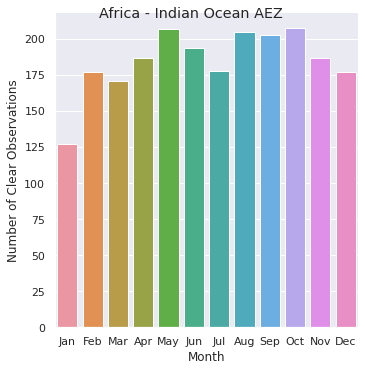

In [78]:
#In order to plot the count of clear observation for each month in each AEZ and examine the seasonality 
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
g = sn.catplot(x='Month', y='Number of Clear Observations', kind='bar', data=input_data, order=Months); #you can add pallette=set1 to change the color scheme 
g.fig.suptitle('Africa - Indian Ocean AEZ');

In [ ]:
#sn.histplot(data=input_data,x='MONTH',hue='Clear_Obs', multiple='stack',bins=25).set_title('Number of WOfS Clear Observations in Sahel AEZ');

### Working on histogram

In [41]:
#Reading the classification table extracted  from 0.9 thresholding of the frequncy for each AEZ exteracted from WOfS_Validation_Africa notebook 
SummaryTable = '../Supplementary_data/Validation/Refined/Continent/AEZs_Assessment/Africa_WOfS_Validation_Class_Northern_T0.9.csv'
CLF = pd.read_csv(SummaryTable,delimiter=",")
CLF

,Unnamed: 0,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,...,WOfS_count,WOfS_Wet_Sum,WOfS_Clear_Sum,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_FREQ,CEO_TYPE,WOfS_TYPE,WOfS_TYPE_O,geometry
0,780,137755561,-8.847683,30.996639,Barren (Bare soil / Rocky Land),12,0,1,3,1,...,8,4,16,0.0,0.500000,0.250000,Dry,Ephemeral,Ephemeral,POINT (-8.847682777000001 30.99663872)
1,781,137755562,29.639551,30.982425,I am unsure,11,1,1,3,1,...,4,4,9,1.0,1.000000,0.444444,Permanent,Permanent,Ephemeral,POINT (29.63955075 30.98242497)
2,782,137755563,31.242680,30.954004,Wetlands - freshwater,4,1,1,2,1,...,5,4,8,0.6,0.800000,0.500000,Ephemeral,Ephemeral,Ephemeral,POINT (31.24268023 30.95400369)
3,783,137755564,-7.271915,30.949085,Wetlands - freshwater,12,1,0,3,0,...,5,0,10,0.6,0.000000,0.000000,Ephemeral,Dry,Dry,POINT (-7.271914702999999 30.94908547)
4,784,137755565,-6.064282,30.936518,Barren (Bare soil / Rocky Land),10,0,0,2,0,...,7,1,14,0.0,0.142857,0.071429,Dry,Ephemeral,Ephemeral,POINT (-6.06428187 30.93651779)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1124,137755553,31.998850,31.150663,Cultivated (Cropland/ Plantation),1,0,0,1,0,...,1,0,1,0.0,0.000000,0.000000,Dry,Dry,Dry,POINT (31.99884991 31.15066328)
187,1125,137755555,-3.786445,31.125477,Barren (Bare soil / Rocky Land),11,0,0,2,0,...,4,0,8,0.0,0.000000,0.000000,Dry,Dry,Dry,POINT (-3.786445068 31.12547734)
188,1126,137755558,30.981503,31.046950,Open water - freshwater,12,1,1,1,1,...,6,6,10,1.0,1.000000,0.600000,Permanent,Permanent,Ephemeral,POINT (30.9815032 31.04695023)
189,1127,137755559,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),11,1,1,1,1,...,8,8,11,1.0,1.000000,0.727273,Permanent,Permanent,Ephemeral,POINT (29.75925689 31.04612972)


In [42]:
CLF=CLF.drop(['Unnamed: 0','MONTH','ACTUAL','CLEAR_OBS','CLASS_WET','Actual_Sum','PREDICTION','WOfS_Sum', 'Actual_count','WOfS_count','geometry','WOfS_Wet_Sum','WOfS_Clear_Sum'], axis=1)
CLF

,PLOT_ID,LON,LAT,CLASS,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_FREQ,CEO_TYPE,WOfS_TYPE,WOfS_TYPE_O
0,137755561,-8.847683,30.996639,Barren (Bare soil / Rocky Land),0.0,0.500000,0.250000,Dry,Ephemeral,Ephemeral
1,137755562,29.639551,30.982425,I am unsure,1.0,1.000000,0.444444,Permanent,Permanent,Ephemeral
2,137755563,31.242680,30.954004,Wetlands - freshwater,0.6,0.800000,0.500000,Ephemeral,Ephemeral,Ephemeral
3,137755564,-7.271915,30.949085,Wetlands - freshwater,0.6,0.000000,0.000000,Ephemeral,Dry,Dry
4,137755565,-6.064282,30.936518,Barren (Bare soil / Rocky Land),0.0,0.142857,0.071429,Dry,Ephemeral,Ephemeral
...,...,...,...,...,...,...,...,...,...,...
186,137755553,31.998850,31.150663,Cultivated (Cropland/ Plantation),0.0,0.000000,0.000000,Dry,Dry,Dry
187,137755555,-3.786445,31.125477,Barren (Bare soil / Rocky Land),0.0,0.000000,0.000000,Dry,Dry,Dry
188,137755558,30.981503,31.046950,Open water - freshwater,1.0,1.000000,0.600000,Permanent,Permanent,Ephemeral
189,137755559,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),1.0,1.000000,0.727273,Permanent,Permanent,Ephemeral


In [43]:
count = CLF.groupby('CLASS',as_index=False,sort=False).last()

In [44]:
count

,CLASS,PLOT_ID,LON,LAT,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_FREQ,CEO_TYPE,WOfS_TYPE,WOfS_TYPE_O
0,Barren (Bare soil / Rocky Land),137755555,-3.786445,31.125477,0.0,0.0,0.000000,Dry,Dry,Dry
1,I am unsure,137755468,4.201530,35.323945,0.0,0.0,0.000000,Dry,Dry,Dry
2,Wetlands - freshwater,137755540,15.583563,31.485550,1.0,1.0,1.000000,Permanent,Permanent,Permanent
3,Cultivated (Cropland/ Plantation),137755560,32.430103,31.028901,0.0,0.5,0.333333,Dry,Ephemeral,Ephemeral
4,Open water - freshwater,137755558,30.981503,31.046950,1.0,1.0,0.600000,Permanent,Permanent,Ephemeral
5,Open water - marine,137755596,33.261516,28.575626,1.0,1.0,1.000000,Permanent,Permanent,Permanent
6,Urban (Settlements/ roads),137755483,3.251965,34.650099,0.0,0.0,0.000000,Dry,Dry,Dry
7,Open water - Constructed (e.g. aquaculture),137755559,29.759257,31.046130,1.0,1.0,0.727273,Permanent,Permanent,Ephemeral
8,Herbaceous/Grassland,137755548,30.222535,31.224068,0.0,1.0,0.571429,Dry,Permanent,Ephemeral


In [45]:
sn.set()
sn.set_theme(color_codes=True)

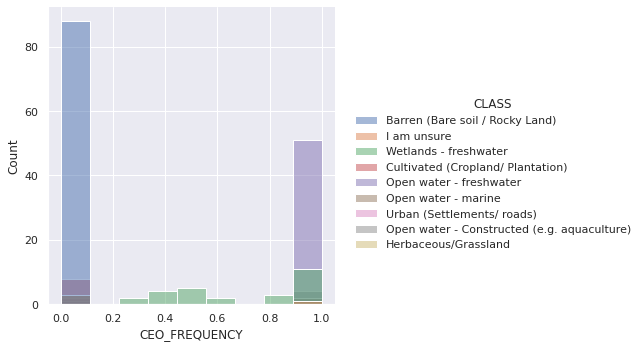

In [46]:
ax1 = sn.displot(CLF, x="CEO_FREQUENCY", hue="CLASS");

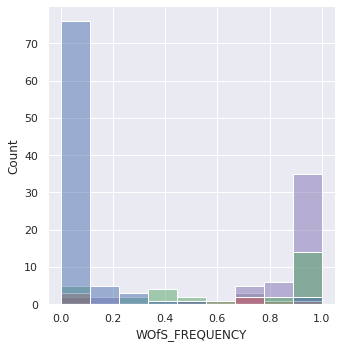

In [47]:
ax2 = sn.displot(CLF, x="WOfS_FREQUENCY", hue="CLASS");
ax2._legend.remove()

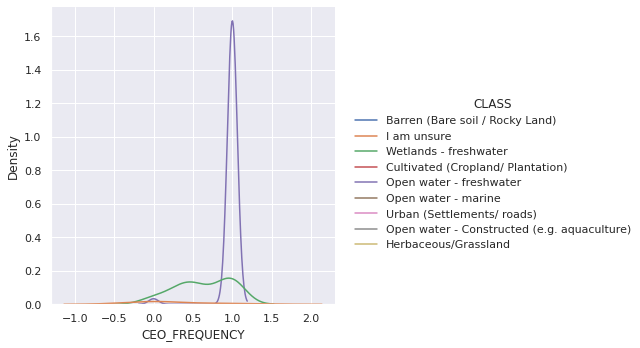

In [54]:
sn.displot(CLF, x="CEO_FREQUENCY", hue="CLASS", kind='kde');

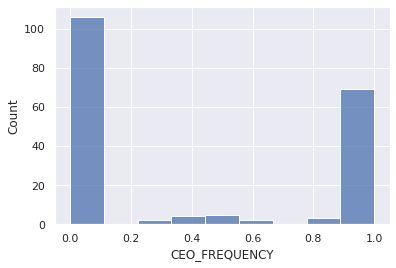

In [49]:
sn.histplot(CLF, x="CEO_FREQUENCY");

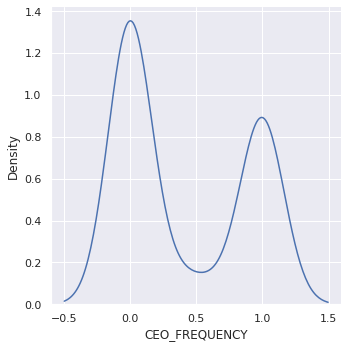

In [50]:
sn.displot(CLF, x="CEO_FREQUENCY", kind='kde');

In [51]:
Sample_ID = CLF[['CLASS','CEO_FREQUENCY','WOfS_FREQUENCY']] 

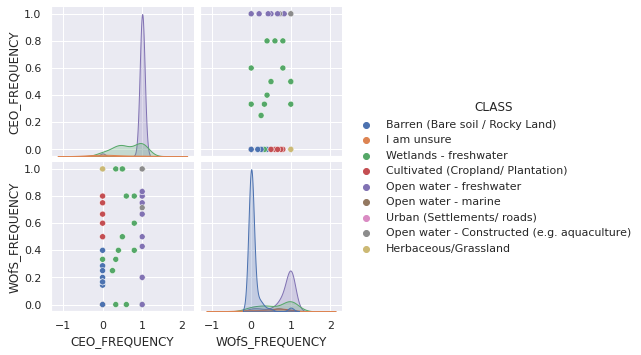

In [52]:
sn.pairplot(Sample_ID, hue='CLASS', size=2.5);

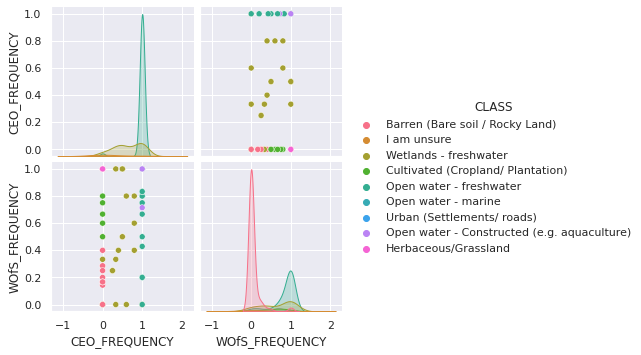

In [53]:
sn.pairplot(Sample_ID,hue='CLASS',diag_kind='kde',kind='scatter',palette='husl')

In [ ]:
print(datacube.__version__)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)